In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

In [5]:
!pip install split-folders

  Using cached split_folders-0.5.1-py3-none-any.whl.metadata (6.2 kB)
Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)


In [6]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/kaggle/input/cropped-stanford-dataset/cropped", output="output",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False) # default values


Copying files: 20578 files [02:17, 149.26 files/s]


In [7]:
train_dir = '/kaggle/working/output/train'
test_dir = '/kaggle/working/output/test'
val_dir = '/kaggle/working/output/val'
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    )
    
# Validation/Test data generator without augmentation
valid_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

# Create test generator
test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 14353 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Found 2153 images belonging to 120 classes.


In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model layers
for layer in base_model.layers[:-30]:  # Keep some layers trainable for fine-tuning
    layer.trainable = False
    
    # Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(120, activation='softmax')(x)
    
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
)
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,698,360 (94.22 MB)

 Trainable params: 15,560,824 (59.36 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

None


In [14]:
callbacks = [
        ModelCheckpoint(
            'best_model.h5.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
    ]

In [15]:
history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=callbacks
    )

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2252 - loss: 3.4158
Epoch 1: val_loss improved from inf to 1.69731, saving model to best_model.h5.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 214s 439ms/step - accuracy: 0.2255 - loss: 3.4139 - val_accuracy: 0.4978 - val_loss: 1.6973 - learning_rate: 0.0010
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5536 - loss: 1.5225
Epoch 2: val_loss improved from 1.69731 to 1.11721, saving model to best_model.h5.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 191s 420ms/step - accuracy: 0.5536 - loss: 1.5224 - val_accuracy: 0.6562 - val_loss: 1.1172 - learning_rate: 0.0010
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6481 - loss: 1.1556
Epoch 3: val_loss improved from 1.11721 to 0.96491, saving model to best_model.h5.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 191s 421ms/step - accuracy: 0.6481 - loss: 1.1556 - val_accuracy: 0.7004 - val_loss: 0.9649 - learning_rate: 0.0010
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0

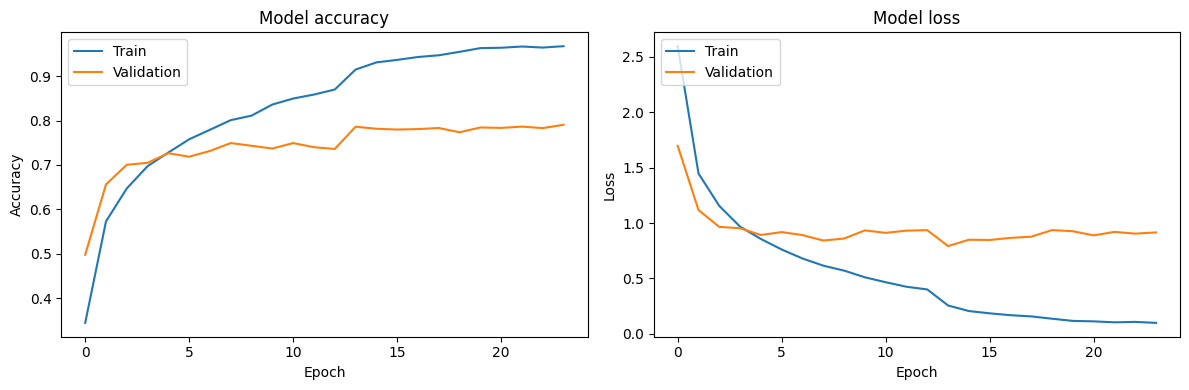

In [20]:
plt.figure(figsize=(12, 4))
    
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
    
plt.tight_layout()
plt.show()

68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8040 - loss: 0.8591
Test Accuracy: 78.96%
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step


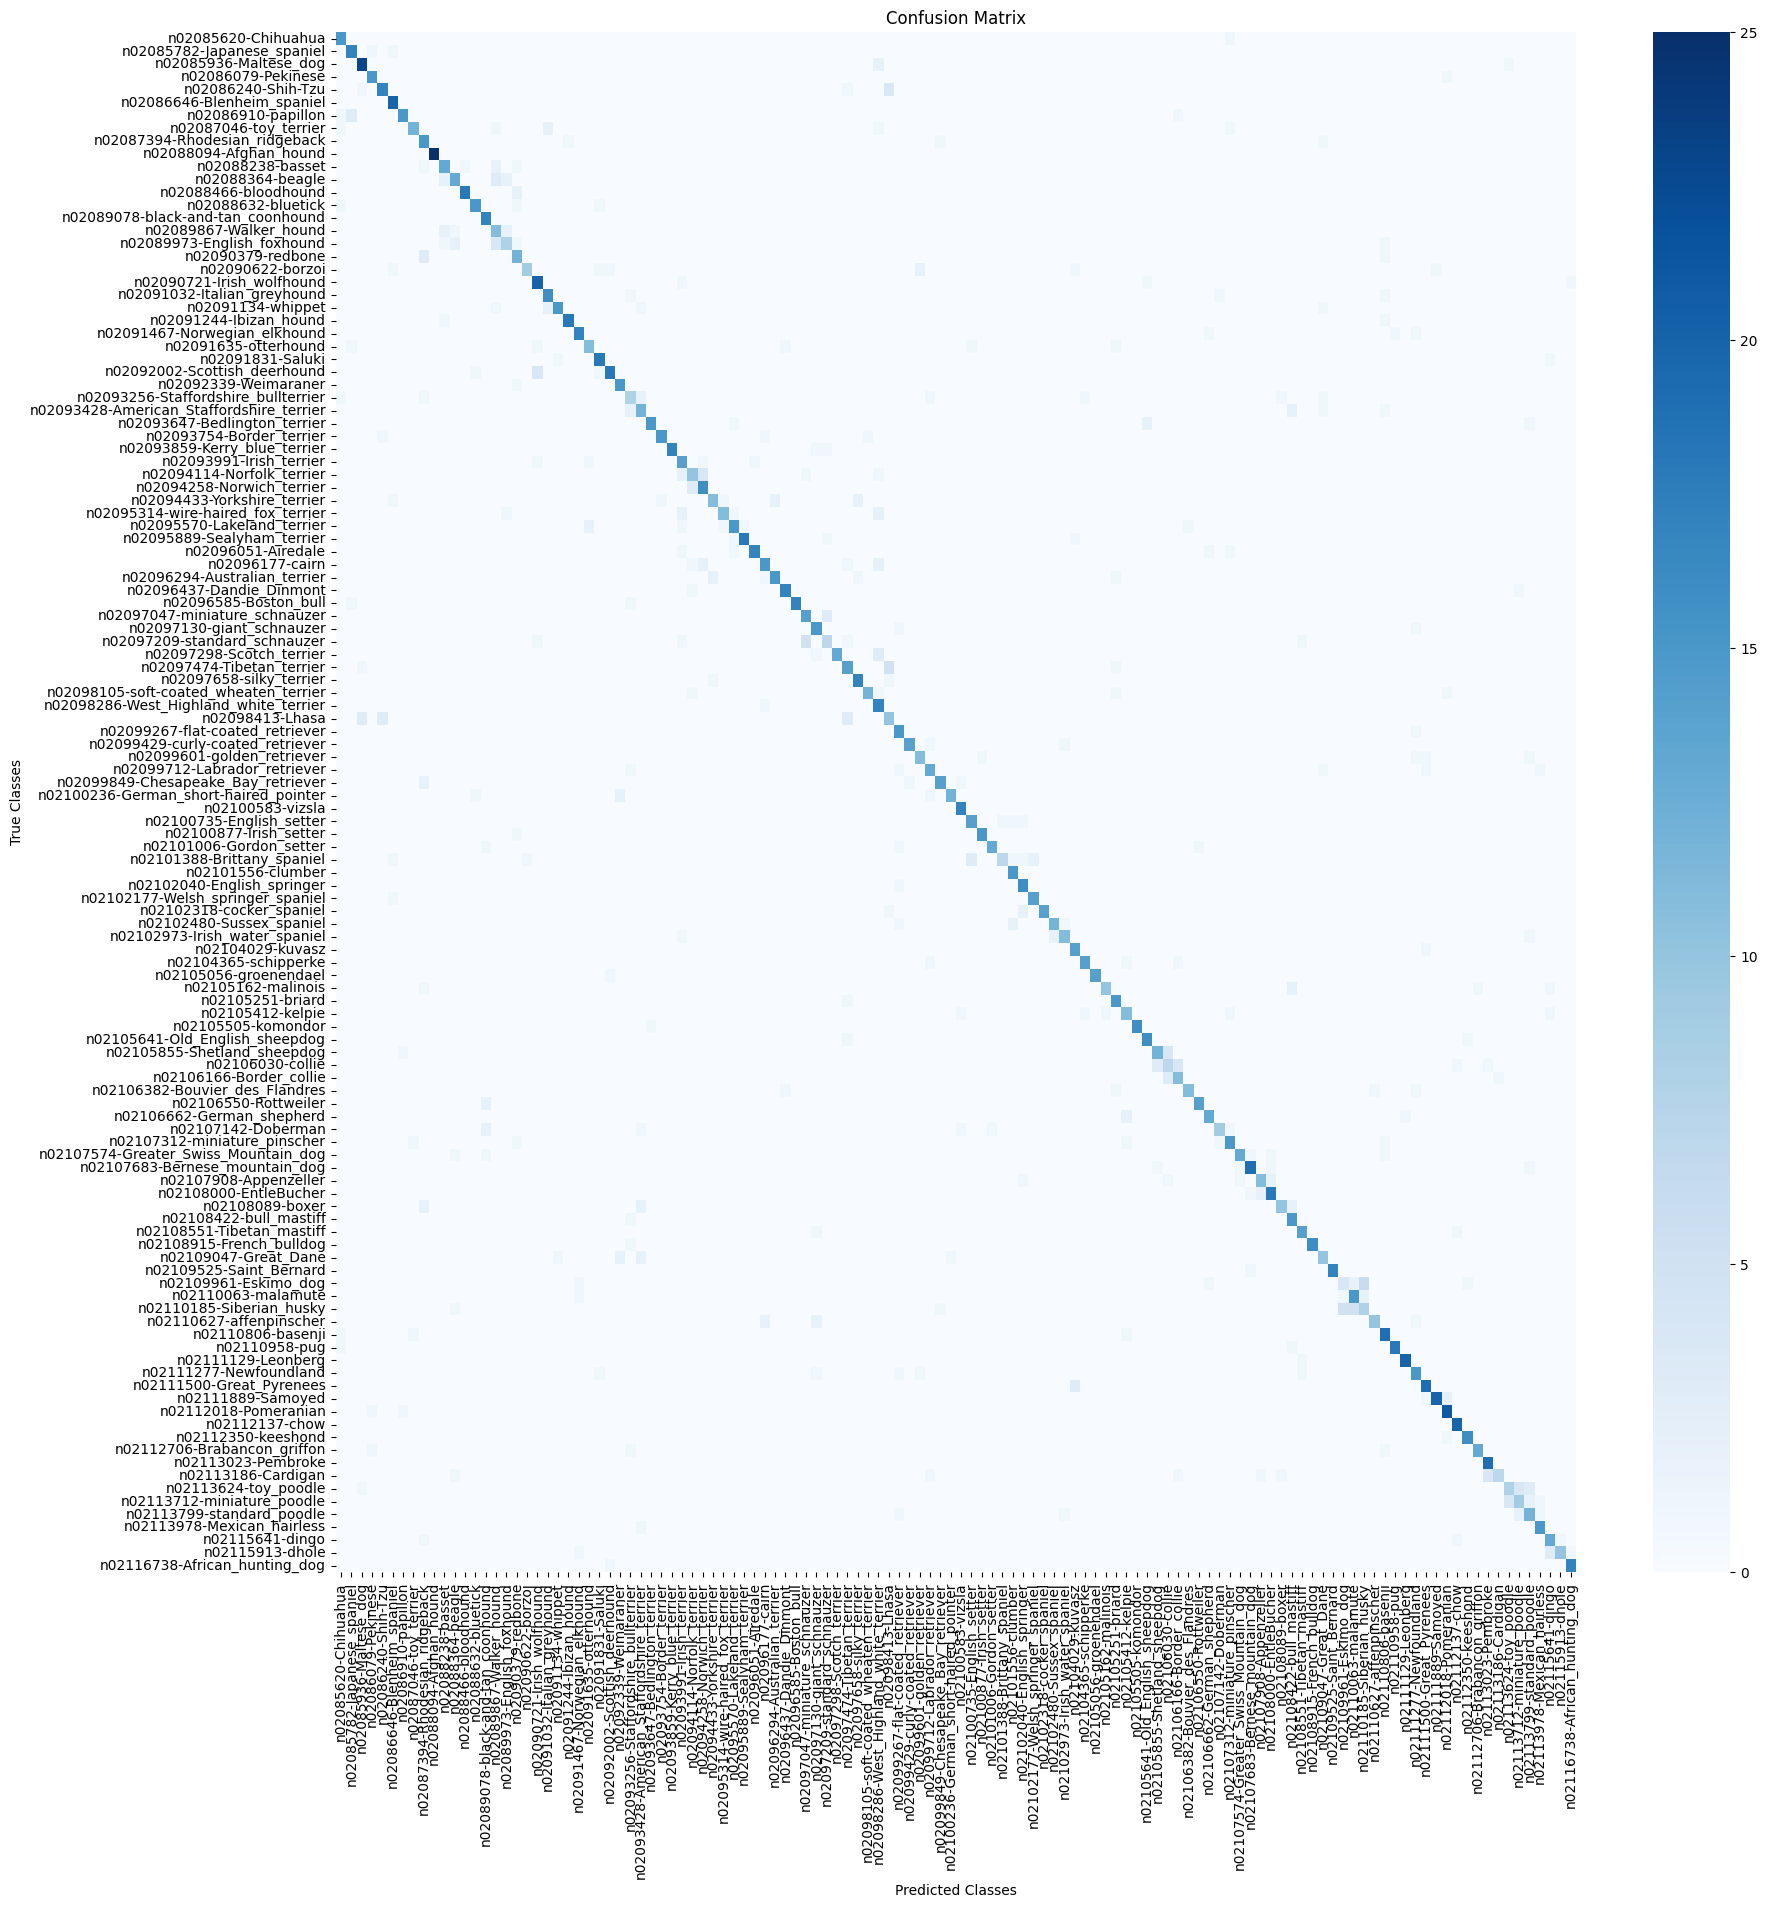

                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.71      0.94      0.81        16
              n02085782-Japanese_spaniel       0.77      0.89      0.83        19
                   n02085936-Maltese_dog       0.79      0.88      0.84        26
                      n02086079-Pekinese       0.83      0.94      0.88        16
                      n02086240-Shih-Tzu       0.81      0.74      0.77        23
              n02086646-Blenheim_spaniel       0.80      1.00      0.89        20
                      n02086910-papillon       0.88      0.75      0.81        20
                   n02087046-toy_terrier       0.86      0.67      0.75        18
           n02087394-Rhodesian_ridgeback       0.58      0.83      0.68        18
                  n02088094-Afghan_hound       1.00      1.00      1.00        25
                        n02088238-basset       0.68      0.72      0.70        18
               

In [21]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions and confusion matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


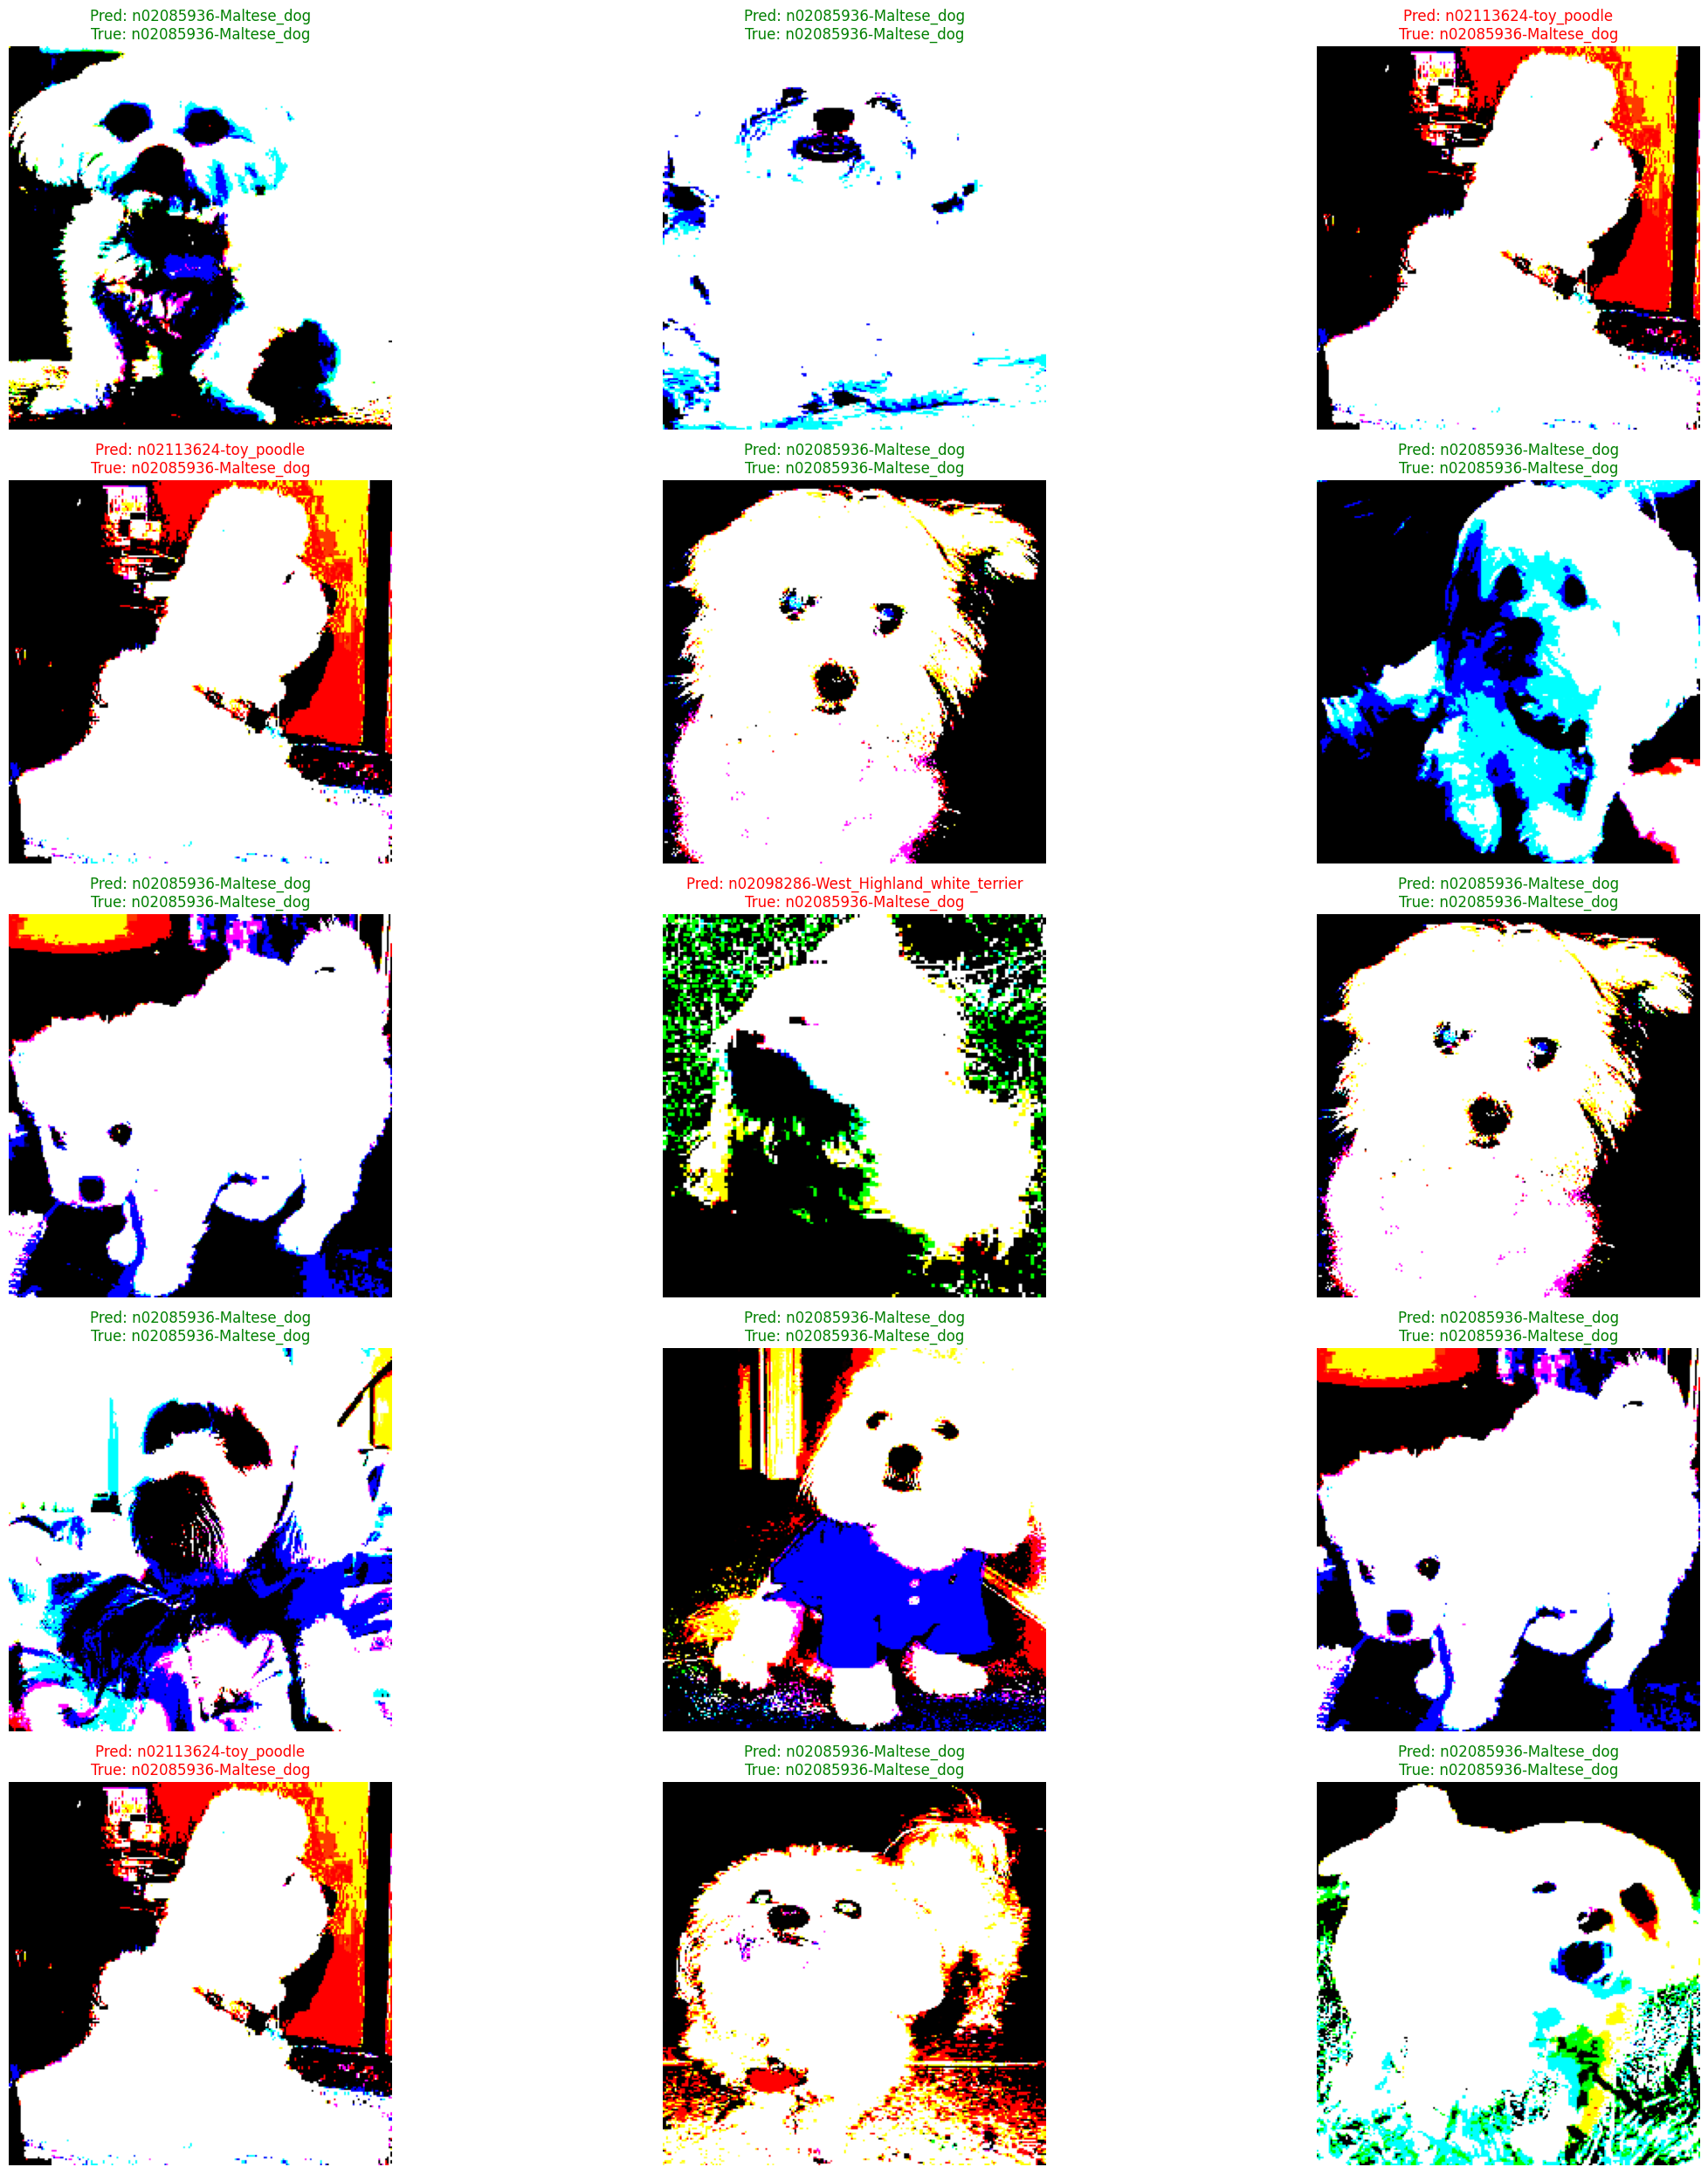

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Set rows, cols for the grid
rows, cols = 5, 3
size = 25

# Get a batch of images and labels from the test generator
X_test, y_test = next(test_generator)  # Retrieve one batch of test data
y_true = np.argmax(y_test, axis=1)  # Convert one-hot to class indices

# Predict the labels for the batch
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Class names
class_names = list(test_generator.class_indices.keys())

# Create a figure for visualization
fig, ax = plt.subplots(rows, cols)
fig.set_size_inches(size, size)

# Plot the images in a grid with predicted and true labels
for i in range(rows):
    for j in range(cols):
        index = np.random.randint(0, len(X_test))  # Randomly select an image from the batch
        img = X_test[index]
        true_label = class_names[y_true[index]]
        pred_label = class_names[y_pred_classes[index]]
        
        # Display the image
        ax[i, j].imshow(img)
        ax[i, j].axis('off')  # Remove axes for better visualization
        
        # Set the title with predicted and true labels
        color = 'green' if true_label == pred_label else 'red'
        ax[i, j].set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


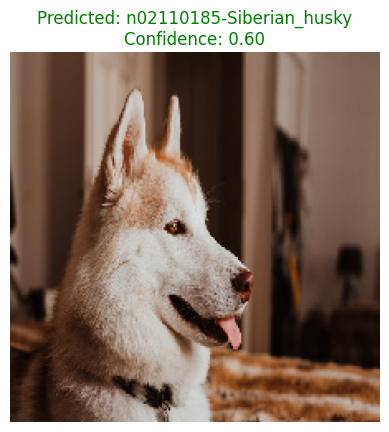

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


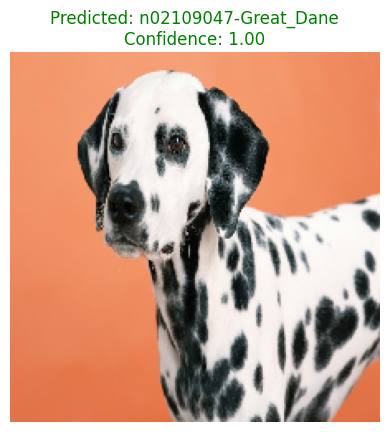

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


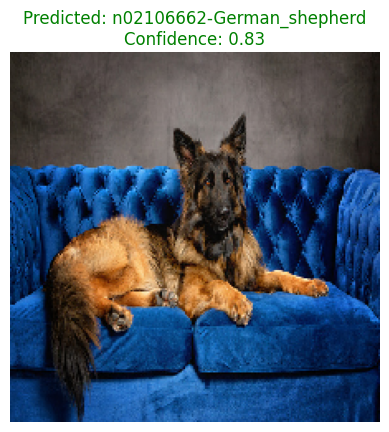

In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def test_single_image(img_path, model, class_names):
    """
    Tests a single image using the trained model and displays the predicted label.

    Args:
        img_path (str): Path to the image file.
        model (keras.Model): Trained model.
        class_names (list): List of class names.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to model's input size
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess using the same function as training

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]  # Get the predicted class name
    confidence = np.max(prediction)  # Confidence score

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}", color='green')
    plt.show()

# Example usage
class_names = list(test_generator.class_indices.keys())  # Get class names from the test generator
test_image_path = '/kaggle/input/dog-breeds/dog-breeds/husky/husky10.jpg'  # Replace with the path to your test image
test_single_image(test_image_path, model, class_names)

test_single_image('/kaggle/input/dog-breeds/dog-breeds/dalmatian/dalmatian16.jpg', model, class_names)
test_single_image('/kaggle/input/dog-breeds/dog-breeds/german-shepherd/german-shepherd107.jpg', model, class_names)
